Representation Learning using Pre-trained CNN's

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, we will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

C:\Users\nahse\AppData\Local\Temp/ipykernel_4164/3756618938.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  train_images = torch.tensor([image.numpy() for image, label in train_dataset])


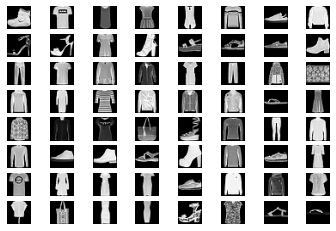

In [ ]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [ ]:
x_train = train_images[torch.where((train_labels == 2)|(train_labels == 6))]
x_test = test_images[torch.where((test_labels == 2)|(test_labels == 6))]

y_train = train_labels[torch.where((train_labels == 2)|(train_labels == 6))]
y_test = test_labels[torch.where((test_labels == 2)|(test_labels == 6))]

y_train = torch.tensor([0 if val == 2 else 1 for val in y_train])
y_test = torch.tensor([0 if val == 2 else 1 for val in y_test])

In [ ]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [ ]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [ ]:
# write your code here
x_train_small = x_train[random_sample]
y_train_small = y_train[random_sample]

We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [ ]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))

# Added map_location CPU to run on just CPU
convnet.load_state_dict(torch.load('pretrained_convnet.pt',map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

C:\Users\nahse\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()
C:\Users\nahse\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [ ]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.


C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.046539
[t-SNE] KL divergence after 1000 iterations: 1.063490


(-53.22366809844971, 49.30532932281494, -52.25156841278076, 39.629898643493654)

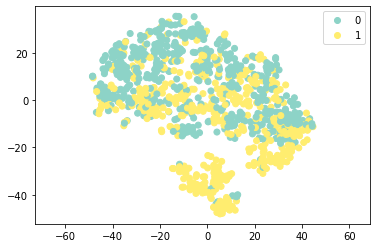

In [ ]:
# write your code here
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=25) 
raw_tsne = tsne.fit_transform(x_train_small[:,0].reshape(len(x_train_small),-1).detach().numpy())

scatter = plt.scatter(raw_tsne[:, 0],
            raw_tsne[:, 1],
            c=y_train_small, cmap='Set3')
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1])
plt.axis('equal')

C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.261436
[t-SNE] KL divergence after 1000 iterations: 0.991353


(-56.05586757659912, 37.10888805389404, -51.56147785186768, 40.511074256896975)

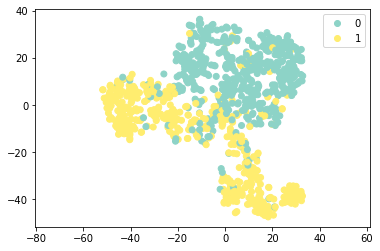

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=25) 
bottle_tsne = tsne.fit_transform(x_train_small_bottleneck_representation.detach().numpy())

scatter = plt.scatter(bottle_tsne[:, 0],
            bottle_tsne[:, 1],
            c=y_train_small, cmap='Set3')
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1])
plt.axis('equal')

In [ ]:
x_train_small_bottleneck_representation.shape

torch.Size([1000, 84])

We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means we should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)


Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [ ]:
# Pretrained CNN test
output = UDA_pytorch_model_transform(convnet,x_test)
y_pred_labels = output[:,[2,6]].argmax(axis=1).view(-1)
print('Test accuracy:', UDA_compute_accuracy(y_pred_labels, y_test))

Test accuracy: 0.891


In [ ]:
def model_eval(model,x_train_arr,y_train_arr,x_test_arr,y_test_arr):
    modelfit = model.fit(x_train_arr,y_train_arr)
    y_pred_labels = modelfit.predict(x_test_arr)
    
    accuracy = accuracy_score(y_test_arr,y_pred_labels)
    print('Test accuracy is: ',accuracy)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 5NN on all training examples
x_train_raw = x_train[:,0].reshape(len(x_train),-1).detach().numpy()
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_flat = x_test[:,0].reshape(len(x_test),-1).detach().numpy()
x_test_bottleneck_rep=  UDA_pytorch_model_transform(intermediate_layer_model, x_test)

print("5NN on Raw Data")
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
model_eval(knn,x_train_raw,y_train,x_test_flat,y_test)

print("\n 5NN on Bottleneck Data")
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
model_eval(knn,x_train_bottleneck_representation,y_train,x_test_bottleneck_rep,y_test)

print("\n Random Forest Classifier on Raw Data")
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0)
model_eval(rf,x_train_raw,y_train,x_test_flat,y_test)

print("\n Random Forest Classifier on Bottleneck Data")
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0)
model_eval(rf,x_train_bottleneck_representation,y_train,x_test_bottleneck_rep,y_test)

5NN on Raw Data
Test accuracy is:  0.856

 5NN on Bottleneck Data
Test accuracy is:  0.888

 Random Forest Classifier on Raw Data
Test accuracy is:  0.8765

 Random Forest Classifier on Bottleneck Data
Test accuracy is:  0.898


| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |      0.891          | this cell stays empty|
| 5-NN             |      0.856          |      0.888           |
| Random forest    |      0.8765         |      0.898           |

 We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. 


  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'TPR')

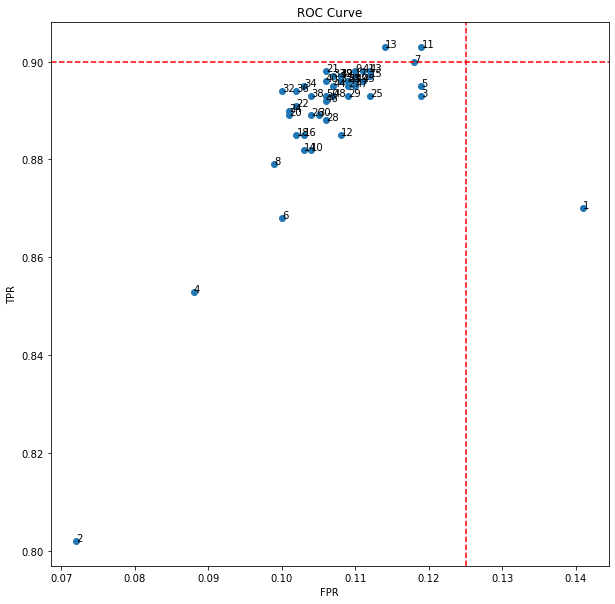

In [ ]:
# write your code here
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

ks = np.arange(1,51)
fpr_l = []
tpr_l = []

from tqdm.notebook import tqdm_notebook
for k in tqdm_notebook(ks):
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    modelfit = knn.fit(x_train_bottleneck_representation,y_train)
    y_pred_labels = modelfit.predict(x_test_bottleneck_rep)
#     y_score = modelfit.predict_proba(x_test_bottleneck_rep)[:,1]
#     fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    cm=confusion_matrix(y_test, y_pred_labels)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    fpr_l.append(fpr)
    tpr_l.append(tpr)

plt.figure(figsize=(10,10))
plt.scatter(fpr_l, tpr_l)

for i,k in enumerate(ks):
    plt.annotate(k,(fpr_l[i],tpr_l[i]))
    
plt.title("ROC Curve")
plt.axvline(x=0.125,color='r',linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

Based on the requirements of the company, an ideal k would be k=13 as it has the highest TPR (tied with k=11) but has an FPR that is lower. 